In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# Motivation  

This notebook is kept around for archival reasons. It was originally part of the work in [this PR](https://github.com/koaning/scikit-mdn/pull/6/files) to speed up inference. 

On slightly larger datasets (10_000) train time is fine (5s) but prediction time is painfully slow. This is because we are looping over all the pdfs created by scipy norm. This can be vectorised natively and just requires broadcasting `ys` to the correct shape.

# Use new cdf function  

Be sure to:
```bash
pip install .
```

In [3]:
from skmdn import MixtureDensityEstimator
import torch

torch.manual_seed(123)

In [4]:
import numpy as np

np.random.seed(seed=123)

from sklearn.datasets import make_moons
# Generate dataset
n_samples = 10_000
X_full, _ = make_moons(n_samples=n_samples, noise=0.1)
X = X_full[:, 0].reshape(-1, 1)  # Use only the first column as input
Y = X_full[:, 1].reshape(-1, 1)  # Predict the second column

# Add some noise to Y to make the problem more suitable for MDN
Y += 0.1 * np.random.randn(n_samples, 1)

In [5]:
mdn = MixtureDensityEstimator()
mdn.fit(X, Y)

MixtureDensityEstimator()

In [6]:
%%timeit
mdn.predict(X)

247 ms ± 27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
new_pred = mdn.predict(X)

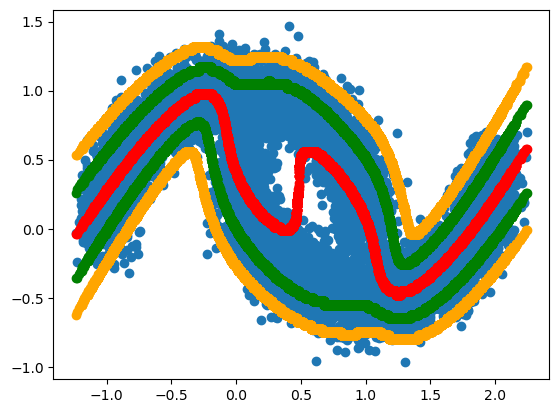

In [17]:
import matplotlib.pyplot as plt

means, quantiles = mdn.predict(X, quantiles=[0.01, 0.1, 0.9, 0.99], resolution=100)

plt.scatter(X, Y)
plt.scatter(X, quantiles[:, 0], color='orange')
plt.scatter(X, quantiles[:, 1], color='green')
plt.scatter(X, quantiles[:, 2], color='green')
plt.scatter(X, quantiles[:, 3], color='orange')
plt.scatter(X, means, color='red')

# Old CDF function

In [9]:
from sklearn.base import BaseEstimator
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from sklearn.datasets import make_moons

class MixtureDensityNetwork(nn.Module):
    '''
    A simple Mixture Density Network that predicts a distribution over a single output variable.
    
    Args:
        input_dim: input dimension
        hidden_dim: hidden layer dimension
        output_dim: output dimension
        n_gaussians: number of gaussians in the mixture model
    '''
    def __init__(self, input_dim, hidden_dim, output_dim, n_gaussians):
        super(MixtureDensityNetwork, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.n_gaussians = n_gaussians

        self.hidden_layer = nn.Linear(input_dim, hidden_dim)
        self.pi_layer = nn.Linear(hidden_dim, n_gaussians)
        self.mu_layer = nn.Linear(hidden_dim, n_gaussians * output_dim)
        self.sigma_layer = nn.Linear(hidden_dim, n_gaussians * output_dim)

    def forward(self, x):
        h = F.softplus(self.hidden_layer(x))
        pi = F.softmax(self.pi_layer(h), dim=1)
        mu = self.mu_layer(h).view(-1, self.n_gaussians, self.output_dim)
        sigma = F.softplus(self.sigma_layer(h)).view(-1, self.n_gaussians, self.output_dim)
        return pi, mu, sigma


def mdn_loss(pi, mu, sigma, target):
    """
    MDN Loss Function
    
    Args:
        pi: (batch_size, n_gaussians)
        mu: (batch_size, n_gaussians)
        sigma: (batch_size, n_gaussians)
        target: (batch_size, 1)
    
    Returns:
        loss: scalar
    """
    normal = torch.distributions.Normal(mu, sigma)
    log_prob = normal.log_prob(target.unsqueeze(1).expand_as(mu))
    weighted_logprob = log_prob + torch.log(pi.unsqueeze(-1))
    return -torch.logsumexp(weighted_logprob, dim=1).mean()


class MixtureDensityEstimator(BaseEstimator):
    '''
    A scikit-learn compatible Mixture Density Estimator.
    
    Args:
        hidden_dim: hidden layer dimension
        n_gaussians: number of gaussians in the mixture model
        epochs: number of epochs
        lr: learning rate
        weight_decay: weight decay for regularisation
    '''
    def __init__(self, hidden_dim=10, n_gaussians=5, epochs=1000, lr=0.01, weight_decay=0.0):
        self.hidden_dim = hidden_dim
        self.n_gaussians = n_gaussians
        self.epochs = epochs
        self.lr = lr
        self.weight_decay = weight_decay
    
    def _cast_torch(self, X, y):
        if not hasattr(self, 'X_width_'):
            self.X_width_ = X.shape[1]
        if not hasattr(self, 'X_min_:'):
            self.X_min_ = X.min(axis=0)
        if not hasattr(self, 'X_max_:'):
            self.X_max_ = X.max(axis=0)
        if not hasattr(self, 'y_min_:'):
            self.y_min_ = y.min()
        if not hasattr(self, 'y_max_:'):
            self.y_max_ = y.max()
        
        assert X.shape[1] == self.X_width_, "Input dimension mismatch"

        return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)
    
    def fit(self, X, y):
        """
        Fit the model to the data.
        
        Args:
            X: (n_samples, n_features)
            y: (n_samples, 1)
        """
        X, y = self._cast_torch(X, y)

        self.model_ = MixtureDensityNetwork(X.shape[1], self.hidden_dim, y.shape[1], self.n_gaussians)
        self.optimizer_ = torch.optim.Adam(self.model_.parameters(), lr=self.lr, weight_decay=self.weight_decay)

        for epoch in range(self.epochs):
            self.optimizer_.zero_grad()
            pi, mu, sigma = self.model_(X)
            loss = mdn_loss(pi, mu, sigma, y)
            loss.backward()
            self.optimizer_.step()

        return self
    
    def partial_fit(self, X, y, n_epochs=1):
        """
        Fit the model to the data for a set number of epochs. Can be used to continue training on new data.
        
        Args:
            X: (n_samples, n_features)
            y: (n_samples, 1)
            n_epochs: number of epochs
        """
        X, y = self._cast_torch(X, y)

        if not self.optimizer_:
            self.optimizer_ = torch.optim.Adam(self.model_.parameters(), lr=self.lr, weight_decay=self.weight_decay)
        for epoch in range(n_epochs):
            self.optimizer_.zero_grad()
            pi, mu, sigma = self.model_(X)
            loss = mdn_loss(pi, mu, sigma, y)
            loss.backward()
            self.optimizer_.step()

        return self
    
    def forward(self, X):
        """
        Calculate the $\pi$, $\mu$ and $\sigma$ outputs n for each sample in X.
        
        Args:
            X: (n_samples, n_features)
        
        Returns:
            pi: (n_samples, n_gaussians)
            mu: (n_samples, n_gaussians)
            sigma: (n_samples, n_gaussians)
        """
        X = torch.FloatTensor(X)
        with torch.no_grad():
            pi, mu, sigma = self.model_(X)
        pi, mu, sigma = pi.detach().numpy(), mu.detach().numpy(), sigma.detach().numpy()
        return pi, mu[:, :, 0], sigma[:, :, 0]

    def pdf(self, X, resolution=100, y_min=None, y_max=None):
        '''
        Compute the probability density function of the model.

        This function computes the pdf for each sample in X.
        It also returns the y values for which the pdf is computed to help with plotting.

        Args:
            X: (n_samples, n_features)
            resolution: number of intervals to compute the quantile over

        Returns:
            pdf: (n_samples, resolution)
            ys: (resolution,)
        '''
        X = torch.FloatTensor(X)
        with torch.no_grad():
            pi, mu, sigma = self.model_(X)
        pi, mu, sigma = self.forward(X)
        ys = np.linspace(
            y_min if y_min is not None else self.y_min_,
            y_max if y_max is not None else self.y_max_,
            resolution
        )
        pdf = np.zeros((pi.shape[0], resolution))
        for i in range(pi.shape[0]):
            for j in range(pi.shape[1]):
                pdf[i] += norm(mu[i, j], sigma[i, j]).pdf(ys) * pi[i, j]
        return pdf, ys
    
    def cdf(self, X, resolution=100):
        '''
        Compute the cumulative probability density function of the model.

        This function computes the cdf for each sample in Xd.
        It also returns the y values for which the cdf is computed to help with plotting.

        Args:
            X: (n_samples, n_features)
            resolution: number of intervals to compute the quantile over

        Returns:
            cdf: (n_samples, resolution)
            ys: (resolution,)
        '''
        pdf, ys = self.pdf(X, resolution=resolution)
        cdf = pdf.cumsum(axis=1)
        cdf /= cdf[:, -1].reshape(-1, 1)
        return cdf, ys
        
    def predict(self, X, quantiles=None, resolution=100):
        '''
        Predicts the variance at risk at a given quantile for each datapoint X.
        
        Args:
            X: (n_samples, n_features)
            quantile: quantile value
            resolution: number of intervals to compute the quantile over

        Returns:
            pred: (n_samples,)
            quantiles: (n_samples, n_quantiles)
        '''
        cdf, ys = self.cdf(X, resolution=resolution)
        
        mean_pred = ys[np.argmax(cdf > 0.5, axis=1)]
        
        if not quantiles:
            return mean_pred
        
        quantile_out = np.zeros((X.shape[0], len(quantiles)))
        for j, q in enumerate(quantiles):
            quantile_out[:, j] = ys[np.argmax(cdf > q, axis=1)]
        return mean_pred, quantile_out

In [10]:
old_mdn = MixtureDensityEstimator()
old_mdn.fit(X, Y)

MixtureDensityEstimator()

In [17]:
%%timeit
old_mdn.predict(X)

33.2 s ± 2.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
pred_old = old_mdn.predict(X)

In [19]:
33.2 / 0.237

140.08438818565403

33.2 / 0.237 -> 140x improvement here

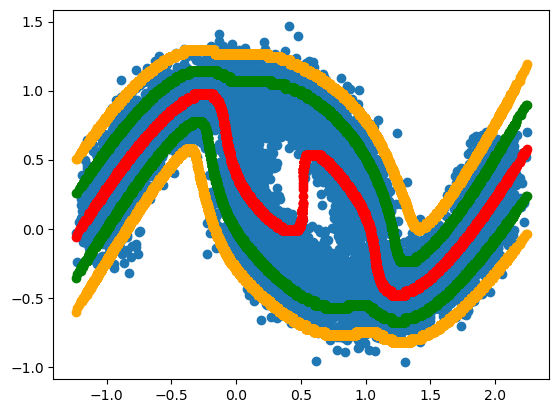

In [ ]:
import matplotlib.pyplot as plt

means_old, quantiles_old = old_mdn.predict(X, quantiles=[0.01, 0.1, 0.9, 0.99], resolution=100)

plt.scatter(X, Y)
plt.scatter(X, quantiles[:, 0], color='orange')
plt.scatter(X, quantiles[:, 1], color='green')
plt.scatter(X, quantiles[:, 2], color='green')
plt.scatter(X, quantiles[:, 3], color='orange')
plt.scatter(X, means, color='red')

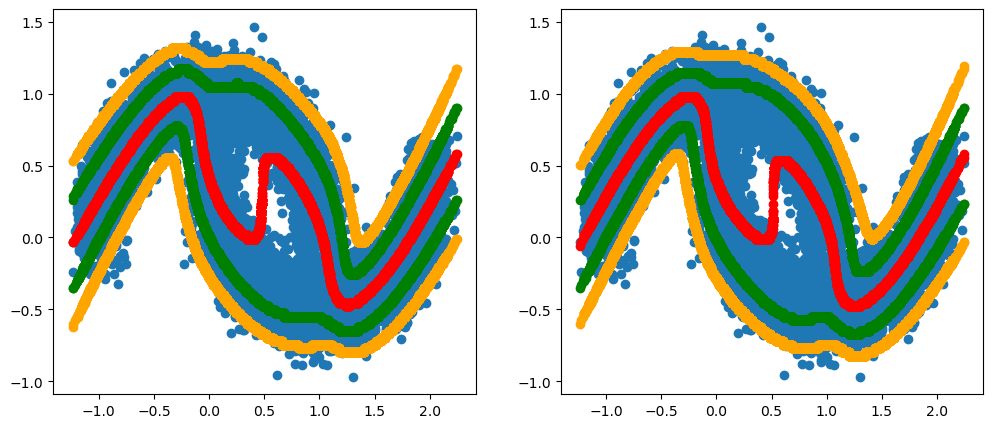

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.scatter(X, Y)
plt.scatter(X, quantiles[:, 0], color='orange')
plt.scatter(X, quantiles[:, 1], color='green')
plt.scatter(X, quantiles[:, 2], color='green')
plt.scatter(X, quantiles[:, 3], color='orange')
plt.scatter(X, means, color='red')

plt.subplot(122)
plt.scatter(X, Y)
plt.scatter(X, quantiles_old[:, 0], color='orange')
plt.scatter(X, quantiles_old[:, 1], color='green')
plt.scatter(X, quantiles_old[:, 2], color='green')
plt.scatter(X, quantiles_old[:, 3], color='orange')
plt.scatter(X, means_old, color='red')